In [1]:
import torch
import torch.nn as nn
import math
import numpy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.model_selection import train_test_split
import torchmetrics
DEVICE = 'cuda' if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else 'cpu')
DEVICE

device(type='mps')

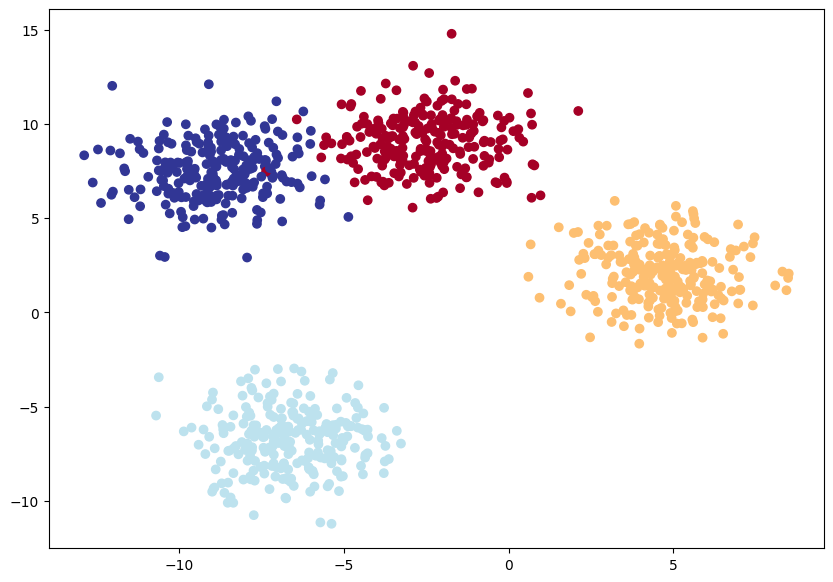

In [109]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RAND_SEED = 42

x_blob, y_blob =  make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RAND_SEED)

X_blob = torch.from_numpy(x_blob).type(torch.float)
Y_blob = torch.from_numpy(y_blob).type(torch.int8)


X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X_blob,Y_blob,test_size=0.2, random_state=RAND_SEED)
X_train = X_train_cpu.to(DEVICE)
X_test = X_test_cpu.to(DEVICE)
y_train = y_train_cpu.to(DEVICE)
y_test = y_test_cpu.to(DEVICE)


plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=Y_blob, cmap=plt.cm.RdYlBu)




In [110]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_features : int, output_features : int, hidden_units:int = 10):
        super().__init__()
        self.layerstack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.layerstack(x)



model = MultiClassClassifier(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=10).to(DEVICE)
model.state_dict

<bound method Module.state_dict of MultiClassClassifier(
  (layerstack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)>

In [111]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [112]:
y_logits = model.forward(X_train[:5])
y_pred = torch.softmax(y_logits, dim=1)
maxxed = torch.argmax(y_pred, dim = 1)
y_logits, y_pred, maxxed

(tensor([[-0.4992,  0.1606,  0.0981, -0.1559],
         [ 0.2616,  2.9872,  0.6222, -0.8351],
         [ 0.8850, -1.0718, -0.5533,  0.2139],
         [ 0.6263, -0.2232, -0.2759, -0.0110],
         [ 0.3372,  2.4796,  0.4757, -0.7040]], device='mps:0',
        grad_fn=<LinearBackward0>),
 tensor([[0.1623, 0.3140, 0.2949, 0.2288],
         [0.0555, 0.8465, 0.0795, 0.0185],
         [0.5292, 0.0748, 0.1256, 0.2705],
         [0.4234, 0.1810, 0.1717, 0.2238],
         [0.0907, 0.7730, 0.1042, 0.0320]], device='mps:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([1, 1, 0, 0, 1], device='mps:0'))

In [113]:
epochs = 150
torch.manual_seed(RAND_SEED)

train_losses = []

for epoch in range(epochs):
    model.train()

    y_logits = model.forward(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.cpu().detach().numpy())
    accuracy = torchmetrics.functional.accuracy(preds=y_pred, target=y_train,task='multiclass', num_classes=NUM_CLASSES)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % int(epochs/10) == 0:
        model.eval()
        test_logits = model.forward(X_test)
        y_test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = torchmetrics.functional.accuracy(preds=y_test_pred, target=y_test,task='multiclass', num_classes=NUM_CLASSES)

        print(f"Epoch {epoch} | Train Loss: {loss:.5f} | Train Accuracy: {accuracy:.5f} || Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.5f}")


Epoch 0 | Train Loss: 2.60789 | Train Accuracy: 0.09125 || Test Loss: 0.65702 | Test Accuracy: 0.85500
Epoch 15 | Train Loss: 0.11489 | Train Accuracy: 0.99125 || Test Loss: 0.10464 | Test Accuracy: 0.99000
Epoch 30 | Train Loss: 0.06417 | Train Accuracy: 0.99125 || Test Loss: 0.05643 | Test Accuracy: 0.99500
Epoch 45 | Train Loss: 0.04860 | Train Accuracy: 0.99125 || Test Loss: 0.04076 | Test Accuracy: 0.99500
Epoch 60 | Train Loss: 0.04138 | Train Accuracy: 0.99125 || Test Loss: 0.03325 | Test Accuracy: 0.99500
Epoch 75 | Train Loss: 0.03730 | Train Accuracy: 0.99125 || Test Loss: 0.02890 | Test Accuracy: 0.99500
Epoch 90 | Train Loss: 0.03471 | Train Accuracy: 0.99125 || Test Loss: 0.02607 | Test Accuracy: 0.99500
Epoch 105 | Train Loss: 0.03295 | Train Accuracy: 0.99125 || Test Loss: 0.02408 | Test Accuracy: 0.99500
Epoch 120 | Train Loss: 0.03167 | Train Accuracy: 0.99125 || Test Loss: 0.02261 | Test Accuracy: 0.99500
Epoch 135 | Train Loss: 0.03071 | Train Accuracy: 0.99125 || Te

Text(0, 0.5, 'Cross Entropy Loss')

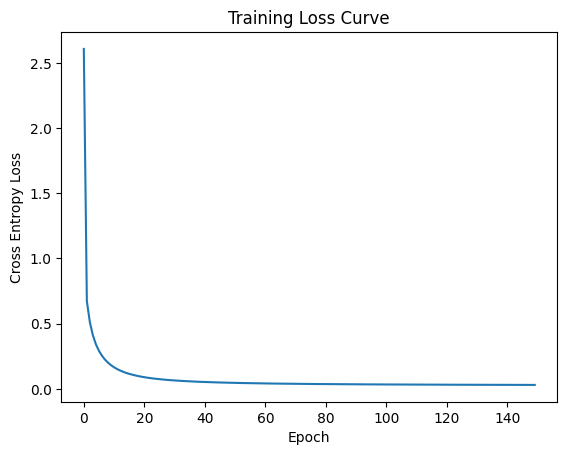

In [114]:
plt.plot([i for i in range(epochs)], train_losses, label = "Train Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

In [115]:
from helper_functions import plot_predictions, plot_decision_boundary

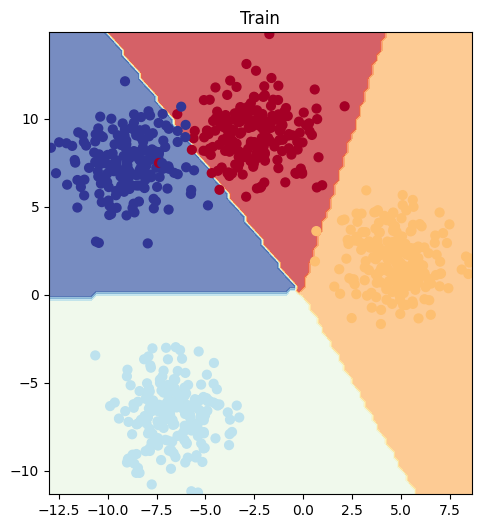

In [116]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

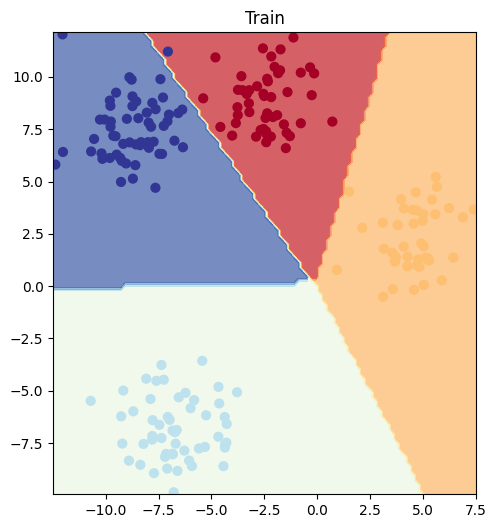

In [117]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_test, y_test)